## Setup

In [1]:
# use full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import os
import numpy as np
os.chdir('..')
import virl
from matplotlib import pyplot as plt
from collections import deque, namedtuple
import random

In [2]:
# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import clone_model

## Agent Implementation

In [3]:
class NNFunctionApproximatorJointKeras():
    """ A basic MLP neural network approximator and estimator using Keras     
    """
    
    def __init__(self, alpha, d_states, n_actions, nn_config, verbose=False):        
        self.alpha = alpha 
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)
        self.model = self._build_model()  
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.alpha, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return


In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'new_state', 'reward'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memory.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

    

BATCH_SIZE  = 64     # number of samples in a batch
REPLAY_MEMORY_SIZE = 1500   # size of the replay buffer

def qlearning_nn(env):
    memory = ReplayMemory(REPLAY_MEMORY_SIZE)
    n_actions = env.action_space.n
    d_states = env.observation_space.shape[0]
    alpha= 0.001          # learning rate/stepsize, 0.001 seems to be a good choice
    nn_config   = [24,24] # size of the hidden layers in the MLP [24,24 seems to be a good choice]
    num_episodes = 50
    epsilon = 1
    epsilon_decay = 0.99995
    discount_factor = 0.95
    
    # Init the two networks
    policy_network = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
    target_network = NNFunctionApproximatorJointKeras(alpha, d_states, n_actions, nn_config)
    target_network.model.set_weights(policy_network.model.get_weights())
    
    best_total_reward = -20
    all_rewards = []
    for episode in range(num_episodes):
        rewards = []
        
        state = env.reset()
        state = np.reshape(state, [1, d_states])
        exploits = 0
        done = False
        while not done:
            random_number = np.random.random()
            if random_number < epsilon and episode < (num_episodes-5):
                #explore
                action = np.random.choice(n_actions)
            else:
                #exploit
                exploits += 1
                action = policy_network.predict(state)[0]
                action = np.argmax(action)

            new_state, reward, done, i = env.step(action=action)
            new_state = np.reshape(new_state, [1, d_states])
            rewards.append(reward)
            
            memory.push(state, action, new_state, reward)
            
            if len(memory) >= BATCH_SIZE:                         
                # Fetch a batch from the replay buffer and extract as numpy arrays 
                transitions = memory.sample(BATCH_SIZE)            
                batch = Transition(*zip(*transitions))                                
                train_rewards = np.array(batch.reward)
                train_states = np.array(batch.state)
                train_new_state = np.array(batch.new_state)
                train_actions = np.array(batch.action)
                
                q_values_for_current_state = policy_network.predict(train_states.reshape(BATCH_SIZE,d_states)) # predict current values for the given states
                q_values_for_new_state     = target_network.predict(train_new_state.reshape(BATCH_SIZE,d_states))                    
                q_values_for_current_state_tmp = train_rewards + discount_factor * np.amax(q_values_for_new_state,axis=1)                
                q_values_for_current_state[ (np.arange(BATCH_SIZE), train_actions.reshape(BATCH_SIZE,).astype(int))] = q_values_for_current_state_tmp                                                                              
                policy_network.update(train_states.reshape(BATCH_SIZE,d_states), q_values_for_current_state) # Update the function approximator 
       
            state = new_state
            epsilon *= epsilon_decay
        
            if done:
                target_network.model.set_weights(policy_network.model.get_weights())
                total_reward = np.sum(rewards)
                all_rewards.append(total_reward)
                print("Episode = " + str(episode) + ". Epsilon = " + str(epsilon) + ". Num Exploits = " + str(exploits) + ". Total Reward = " + str(total_reward))
                
                if total_reward > best_total_reward:
                    best_total_reward = total_reward
                    print("Best total reward has been updated to " + str(best_total_reward) + ", for episode " + str(episode))
                    
    return all_rewards
    
env = virl.Epidemic(stochastic=False, noisy=False)
r = qlearning_nn(env) 

Episode = 0. Epsilon = 0.9974033122391917. Num Exploits = 0. Total Reward = -1.6735489421270489
Best total reward has been updated to -1.6735489421270489, for episode 0
Episode = 1. Epsilon = 0.99481336726571. Num Exploits = 0. Total Reward = -1.6236571279020733
Best total reward has been updated to -1.6236571279020733, for episode 1
Episode = 2. Epsilon = 0.992230147570642. Num Exploits = 0. Total Reward = -1.4853998204427141
Best total reward has been updated to -1.4853998204427141, for episode 2
Episode = 3. Epsilon = 0.9896536356905399. Num Exploits = 0. Total Reward = -2.0474492232313617
Episode = 4. Epsilon = 0.987083814207303. Num Exploits = 0. Total Reward = -1.3939319402104162
Best total reward has been updated to -1.3939319402104162, for episode 4
Episode = 5. Epsilon = 0.9845206657480585. Num Exploits = 0. Total Reward = -1.97064252482292
Episode = 6. Epsilon = 0.9819641729850472. Num Exploits = 0. Total Reward = -1.5074120396267308
Episode = 7. Epsilon = 0.9794143186355041.

Text(0, 0.5, 'Total Rewards')

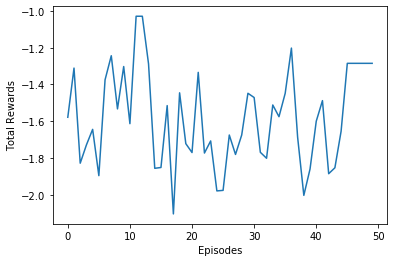

In [13]:
plt.plot(r)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")